<a href="https://colab.research.google.com/github/camillerose/DeepLearning_MonkeyClassification/blob/master/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!curl https://course-v3.fast.ai/setup/colab | bash

from fastai import *
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   287  100   287    0     0   1043      0 --:--:-- --:--:-- --:--:--  1043
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">'
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


First I will train the model then I will tune it.

In [4]:
path = Path('*******')
os.listdir(path)

['capuchins',
 'marmosets',
 'night',
 'saki',
 'spider',
 'tamarins',
 'squirrel',
 'woolly',
 'models',
 'howlers']

The training set is in the current folder, set aside 20% for validation (will create a validation set automatically and randomly).

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)

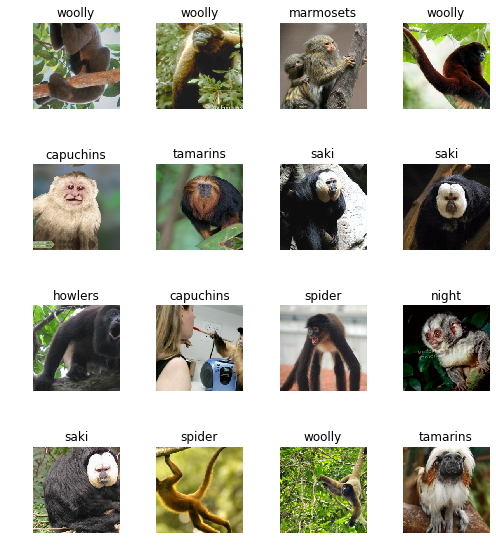

In [16]:
data.show_batch(rows=4, figsize=(7,8))

In [17]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['capuchins',
  'howlers',
  'marmosets',
  'night',
  'saki',
  'spider',
  'squirrel',
  'tamarins',
  'woolly'],
 9,
 294,
 73)

# ResNet34

I will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. I will train for 4 epochs (4 cycles through all the data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.521301,1.653543,0.589041,00:19
1,1.856797,0.618328,0.917808,00:20
2,1.376375,0.358558,0.931507,00:19
3,1.082675,0.314254,0.931507,00:19


93% accuracy is pretty good!

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

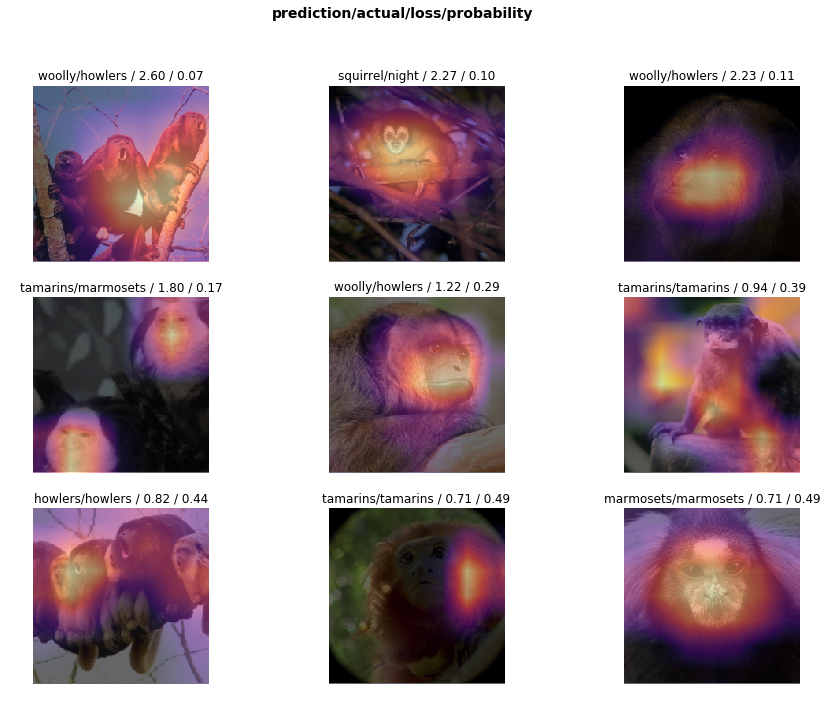

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

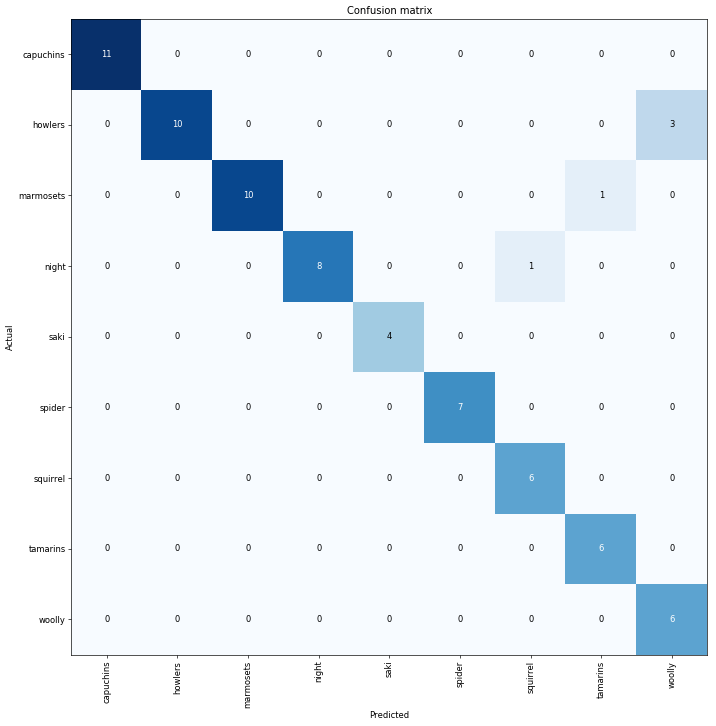

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=1) # actual, predicted, number of occurrences

[('howlers', 'woolly', 3),
 ('marmosets', 'tamarins', 1),
 ('night', 'squirrel', 1)]

In [0]:
learn.save('monkey34-stage1')

## Unfreeze model, fine tuning, learning rate

In [0]:
learn.unfreeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We want to find the strongest downward slope which indicates the model is learning well.

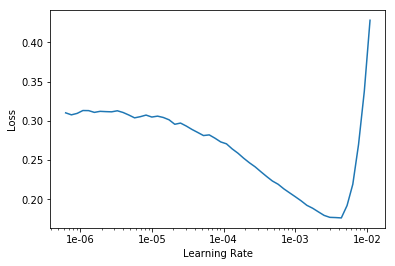

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(2, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.315492,0.850562,0.739726,00:19
1,0.337886,0.745076,0.767123,00:20


Model is better without unfreezing and fine tuning learning rate.

In [0]:
learn.save('monkey34-stage2')

# ResNet50

In [0]:
learn50 = cnn_learner(data, models.resnet50, metrics=accuracy)

In [35]:
learn50.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.171717,1.067712,0.794521,00:21
1,1.211353,0.303727,0.931507,00:21
2,0.835385,0.173744,0.972603,00:20
3,0.636007,0.151477,0.972603,00:20


Performs better than ResNet34!

In [36]:
interp = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

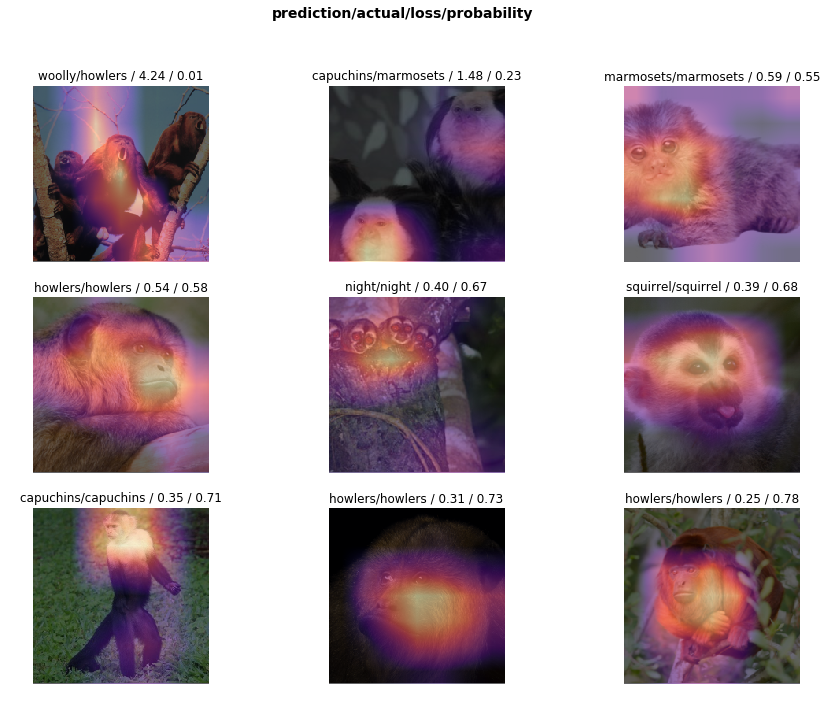

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

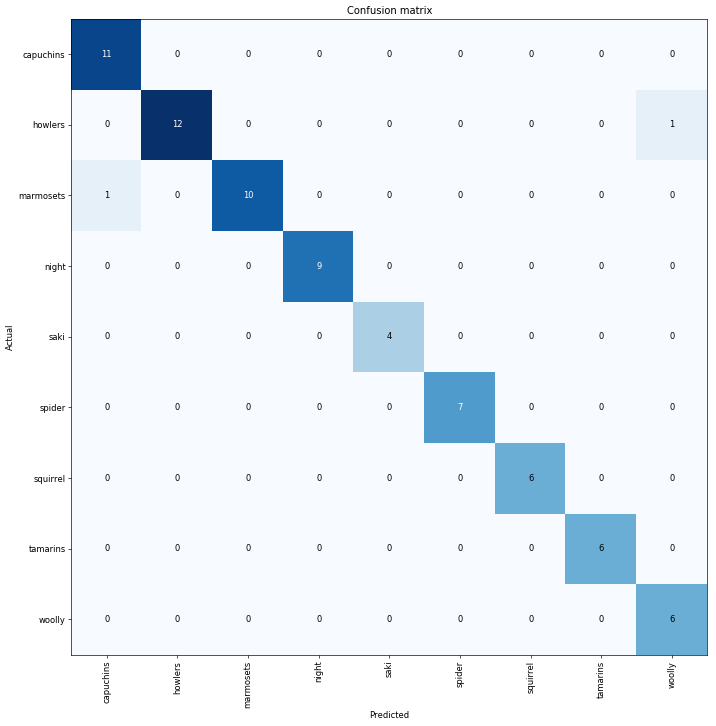

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=1) # actual, predicted, number of occurrences

[('howlers', 'woolly', 1), ('marmosets', 'capuchins', 1)]

In [0]:
learn50.save('monkey50-stage1')

Unfreeze and try to fine tune the model

In [0]:
learn50.unfreeze()

In [42]:
learn50.fit_one_cycle(4, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.138656,1.537914,0.684932,00:21
1,0.322881,1.102471,0.712329,00:20
2,0.325464,1.641210,0.657534,00:21
3,0.285706,1.003401,0.753425,00:21


Model is overfitting. Keep with the defaults.

In [0]:
learn50.save('monkey50-stage2')